In [4]:
%run "08222019_functions.ipynb"

In [5]:
tbl_samples = (
    etl
    .fromtsv('samples.meta.txt')
)
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [6]:
calldata_hap_phase2.tree()

/
 ├── 2L
 │   ├── calldata
 │   │   └── GT (8906423, 1164, 2) int8
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (8906423,) |S1
 │       ├── POS (8906423,) int32
 │       └── REF (8906423,) |S1
 ├── 2R
 │   ├── calldata
 │   │   └── GT (12047846, 1164, 2) int8
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (12047846,) |S1
 │       ├── POS (12047846,) int32
 │       └── REF (12047846,) |S1
 ├── 3L
 │   ├── calldata
 │   │   └── GT (7897666, 1164, 2) int8
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (7897666,) |S1
 │       ├── POS (7897666,) int32
 │       └── REF (7897666,) |S1
 ├── 3R
 │   ├── calldata
 │   │   └── GT (10752701, 1164, 2) int8
 │   ├── samples (1164,) |S8
 │   └── variants
 │       ├── ALT (10752701,) |S1
 │       ├── POS (10752701,) int32
 │       └── REF (10752701,) |S1
 └── X
     ├── calldata
     │   └── GT (4472265, 1099, 2) int8
     ├── samples (1099,) |S8
     └── variants
         ├── ALT (4472265,) |S1
         ├── POS (4472265,) int32
         └── REF (4472265,) |S1

In [7]:
allel.SortedIndex(calldata_hap_phase2['3L']['variants']['POS'][:])

0,1,2,3,4,...,7897661,7897662,7897663,7897664,7897665
9790,9791,9798,9812,9815,...,41956530,41956532,41956537,41956541,41956551


In [10]:
fasta_fn = 'data/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn)

In [11]:
sorted(genome.keys())

['2L', '2R', '3L', '3R', 'UNKN', 'X', 'Y_unplaced']

-----------------------------------------------------

## DXY pairwise calc

In [12]:
import sys
import gc
import datetime
import humanize
from humanize import naturalsize, intcomma, intword


def log(*msg):
    print(' '.join(map(str, msg)), file=sys.stdout)
    sys.stdout.flush()
    
from contextlib import contextmanager

@contextmanager
def timer(*msg):
    before = datetime.datetime.now()
    try:
        yield
    except:
        after = datetime.datetime.now()
        elapsed = (after - before).total_seconds()
        done = 'errored after %s' % humanize.naturaldelta(elapsed)
        if not msg:
            msg = done
        else:
            msg = ', '.join(map(str, msg)) + ', ' + done
        print(msg, file=sys.stderr)
        sys.stderr.flush()   
        raise
    else:
        after = datetime.datetime.now()
        elapsed = (after - before).total_seconds()
        done = 'done in %s' % humanize.naturaldelta(elapsed)
        if not msg:
            msg = done
        else:
            msg = ', '.join(map(str, msg)) + ', ' + done
        print(msg, file=sys.stdout)
        sys.stdout.flush()

In [13]:
dist_dn_template = os.path.join('/bucket/dist_haps/')
dist_fn_template = '{chrom}.{start:08d}.{stop:08d}.npy'

In [14]:
def compute_dxy_distance_matrices(chrom, window_size):
    dist_dn = dist_dn_template.format(metric='dxy', window_size=window_size)
    if not os.path.exists(dist_dn):
        os.makedirs(dist_dn)
        
    # open haplotypes
    callset = zarr.open(phase2happath)
    
    # load accessibility map
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    # determine accessible positions
    pos_accessible, = np.nonzero(is_accessible)
    
    # define equally accessible windows
    window_starts = pos_accessible[0:None:window_size]
    window_stops = pos_accessible[window_size-1:None:window_size]
    
    # add final window to end of chromosome
    window_starts = np.append(window_starts, [window_stops[-1] + 1])
    window_stops = np.append(window_stops, [len(genome['3L chromosome:AgamP3:3L:1:41963435:1'])])
    
    # load variant positions
    pos = allel.SortedIndex(calldata_hap_phase2[chrom]['variants']['POS'][:])

    # iterate over windows
    for window_start, window_stop in zip(window_starts, window_stops):
        
        # distance matrix file name
        dist_fn = dist_fn_template.format(chrom=chrom, start=window_start, stop=window_stop)
        dist_path = os.path.join(dist_dn, dist_fn)
        
        # stay dry
        if os.path.exists(dist_path):
            log('skipping', dist_path)
            
        else:
            log('building', dist_path)
            gc.collect()
            
            with timer():
                
                # locate the window
                loc = pos.locate_range(window_start, window_stop)
                print (loc.start, loc.stop)

                # load data
                genotypes_phase2_call = calldata_hap_phase2[chrom]["calldata/GT"]
                genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call[loc])
                haplotypes = genotypes_phase2.to_haplotypes()
                n_variants = genotypes_phase2.shape[0]
                log('variants:', n_variants)


                # compute hamming distance
                dist = allel.pairwise_distance(haplotypes[:], metric='hamming')
                log('hamming distance, max:', dist.max(), ', min:', dist.min())

                # adjust by accessible window size
                n_bases = np.count_nonzero(is_accessible[window_start:window_stop+1])
                log('window accessible size:', n_bases)
                dist = dist * n_variants / n_bases
                log('dxy distance, max:', dist.max(), ', min:', dist.min())

                # save
                np.save(dist_path, dist)

In [51]:
#dxy_3L = compute_dxy_distance_matrices('3L', 50000)

building dist_haps/3L.00009778.00339867.npy
0 5178
variants: 5178
hamming distance, max: 0.0610274237157 , min: 0.0
window accessible size: 50000
dxy distance, max: 0.00632 , min: 0.0
done in 12 seconds
building dist_haps/3L.00339868.00730787.npy
5178 10720
variants: 5542
hamming distance, max: 0.0591844099603 , min: 0.0
window accessible size: 50000
dxy distance, max: 0.00656 , min: 0.0
done in 13 seconds
building dist_haps/3L.00730788.00873296.npy
10720 16243
variants: 5523
hamming distance, max: 0.0449031323556 , min: 0.0
window accessible size: 50000
dxy distance, max: 0.00496 , min: 0.0
done in 12 seconds
building dist_haps/3L.00873297.01243275.npy
16243 22731
variants: 6488
hamming distance, max: 0.0618064118372 , min: 0.0
window accessible size: 50000
dxy distance, max: 0.00802 , min: 0.0
done in 15 seconds
building dist_haps/3L.01243276.01490935.npy
22731 28505
variants: 5774
hamming distance, max: 0.0661586421891 , min: 0.0
window accessible size: 50000
dxy distance, max: 0.00

In [52]:
#dxy_3R = compute_dxy_distance_matrices('3R', 50000)

--------------------------------

## DXY plotting

In [16]:
palette = sns.color_palette()

In [17]:
distscan_dir = ' /bucket/dist_haps/'
!ls -lh {distscan_dir}* | head

-rwxrwxrwx 1 jovyan 1000 21M Sep 13 09:08 /bucket/dist_haps/3L.00009778.00339867.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 13 09:09 /bucket/dist_haps/3L.00339868.00730787.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 13 09:09 /bucket/dist_haps/3L.00730788.00873296.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:13 /bucket/dist_haps/3R.00000020.00065900.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:14 /bucket/dist_haps/3R.00065901.00134416.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:15 /bucket/dist_haps/3R.00134417.00189553.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:16 /bucket/dist_haps/3R.00189554.00243509.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:16 /bucket/dist_haps/3R.00243510.00296887.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:17 /bucket/dist_haps/3R.00296888.00352301.npy
-rwxrwxrwx 1 jovyan 1000 21M Sep 12 14:18 /bucket/dist_haps/3R.00352302.00411698.npy
ls: write error: Broken pipe


In [18]:
def open_dscan(chrom):

    # find the underlying matrix file names, we need these to get window boundaries
    dfns = sorted(glob.glob(os.path.join(distscan_dir, chrom + '*.npy')))
    bnms = [os.path.basename(f) for f in dfns]
    windows = np.array([[int(b.split('.')[1]), int(b.split('.')[2])] for b in bnms])
    n_windows = len(windows)
#     log(n_windows, 'windows')

    # compile into a single array
    dscan_rootdir = os.path.join(distscan_dir, '%s.bcolz' % chrom)
    if not os.path.exists(dscan_rootdir):
        log('loading', dscan_rootdir)

        # load up the first matrix to determine shape
        d = np.load(dfns[0])
        n_pairs = d.shape[0]
#         log(n_pairs, 'pairs')

        # setup bcolz array
        dscan = bcolz.carray(np.empty((0, n_pairs), dtype='f4'), 
                             cparams=bcolz.cparams(cname='zlib', clevel=1),
                             rootdir=dscan_rootdir,
                             mode='w',
                             expectedlen=n_windows)

        # load one row at a time
        for i, dfn in enumerate(dfns):
            if i > 0 and i % 20 == 0:
                log(i, dfn)
            dscan.append(np.load(dfn, mmap_mode='r'))
            dscan.flush()
        
    # open/re-open in read-only mode
    dscan = bcolz.carray(rootdir=dscan_rootdir, mode='r')

    return windows, dscan

In [20]:
open_dscan('3R')

loading  /bucket/dist_haps/3R.bcolz


IndexError: list index out of range

In [12]:
def sample_to_haplotype_indices(sidx):
    return list(itertools.chain(*[[ix*2, ix*2+1] for ix in sidx])) 

In [60]:
def extract_2pop_dscan(chrom, pop1, pop2):

    callset = zarr.open(phase2happath)
    samples = tbl_samples
    n_samples = len(samples)
    n_haplotypes = 2 * n_samples
    
    # load dscan
    windows, dscan = open_dscan(chrom)

    # locate sample indices
    pop1_sample_indices=tbl_samples.population[tbl_samples.population == pop1].index.tolist()
    pop2_sample_indices=tbl_samples.population[tbl_samples.population == pop2].index.tolist()

    # locate haplotype indices
    pop1_haplotype_indices = sample_to_haplotype_indices(pop1_sample_indices)
    pop2_haplotype_indices = sample_to_haplotype_indices(pop2_sample_indices)
    
    # locate indices of pairwise comparisons within and between populations
    dw1_ix = allel.condensed_coords_within(pop1_haplotype_indices, n_haplotypes)
    dw2_ix = allel.condensed_coords_within(pop2_haplotype_indices, n_haplotypes)
    db_ix = allel.condensed_coords_between(pop1_haplotype_indices, pop2_haplotype_indices, n_haplotypes)
    
    # extract pairwise distances
    dw1 = allel.chunked.core.take(dscan, dw1_ix, axis=1)[:]
    dw2 = allel.chunked.core.take(dscan, dw2_ix, axis=1)[:]
    db = allel.chunked.core.take(dscan, db_ix, axis=1)[:]
    
    return windows, dw1, dw2, db


In [61]:
extract_2pop_dscan('3L', 'BFcol', 'BFgam')

[67, 81, 82, 83, 91, 92, 93, 97, 98, 99, 100, 101, 102, 103, 104, 105, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 169, 173, 174, 182, 184, 185, 186, 188, 189, 191, 192, 194, 197, 203, 204, 205, 206, 207, 210, 211, 214, 215, 218, 219, 220, 221, 222, 223, 224, 226, 227, 229, 230, 232, 233]


(array([[    9778,   339867],
        [  339868,   730787],
        [  730788,   873296],
        [  873297,  1243275],
        [ 1243276,  1490935],
        [ 1490936,  1622713],
        [ 1622714,  1737176],
        [ 1737177,  1833911],
        [ 1833912,  1918172],
        [ 1918173,  1989789],
        [ 1989790,  2044538],
        [ 2044539,  2108439],
        [ 2108440,  2171520],
        [ 2171521,  2239834],
        [ 2239835,  2322734],
        [ 2322735,  2412740],
        [ 2412741,  2487625],
        [ 2487627,  2586161],
        [ 2586162,  2670331],
        [ 2670332,  2773590],
        [ 2773591,  2850669],
        [ 2850670,  2919374],
        [ 2919375,  2997768],
        [ 2997769,  3073996],
        [ 3073997,  3158413],
        [ 3158414,  3235327],
        [ 3235328,  3312185],
        [ 3312186,  3378695],
        [ 3378696,  3430757],
        [ 3430758,  3487521],
        [ 3487522,  3544052],
        [ 3544053,  3595558],
        [ 3595559,  3659830],
        [ 

In [63]:
def plot_dist_scan(windows, d, ylim=(0, 0.016), title=None, color=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(8, 1.5))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # median
    y = np.median(d, axis=1)
    ax.plot(x, y, color=color, lw=1)
    
    # interquartile range
    y1 = np.percentile(d, 25, axis=1)
    y2 = np.percentile(d, 75, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.6)
    
    # 5-95 range
    y1 = np.percentile(d, 5, axis=1)
    y2 = np.percentile(d, 95, axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.4)
    
    # total range
    y1 = d.min(axis=1)
    y2 = d.max(axis=1)
    ax.fill_between(x, y1, y2, color=color, alpha=.2)
    
    # tidy up
    ax.set_ylim(*ylim)
    
    # legend
    handles = list()
    # median
    l = plt.Line2D([], [], color=color, linestyle='-', linewidth=2, label='median')
    handles.append(l)
    # percentiles
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.6, lw=0, label='25-75th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.4, lw=0, label='5-95th percentiles')
    handles.append(r)
    r = plt.Rectangle([0, 0], 1, 1, color=color, alpha=.2, lw=0, label='min-max')
    handles.append(r)
    ax.legend(handles=handles, bbox_to_anchor=[1, 1], loc='upper left')    
    ax.set_yticks([0, .005, .01, .015])
    ax.set_xlim(0, windows[-1, -1])
    

In [64]:
def plot_gmin(windows, d, title=None, ax=None):
    
    # set up figure
    if ax is None:
        fig, ax = subplots(figsize=(8, 1.5))
    if title is not None:
        ax.set_title(title, fontweight='bold')

    # window centres
    x = np.array(windows).mean(axis=1)

    # Gmin
    y = d.min(axis=1) / d.mean(axis=1)
    ax.plot(x, y, color='k', lw=1, linestyle='-')
        
    # tidy up
    ax.set_ylabel(r'$G_{min}$', rotation=0, ha='right', va='center')
    ax.set_xlim(0, windows[-1, -1])
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

In [65]:
autosomes = '3L'

In [85]:
def run_2pop_analysis(pop1, pop2):
    for chrom in autosomes:
        fig = plt.figure(figsize=(7, 6))
        windows, dw1, dw2, db = extract_2pop_dscan(chrom, pop1, pop2)
        
        ax = fig.add_subplot(4, 1, 1)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw1, title='%s, %s' % (pop1, chrom), color=palette[0], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 2)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, dw2, title='%s, %s' % (pop2, chrom), color=palette[1], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$\pi$', rotation=0, ha='right', va='center')
        
        ax = fig.add_subplot(4, 1, 3)
        sns.despine(ax=ax, bottom=True, offset=5)
        plot_dist_scan(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), color=palette[2], ax=ax)
        ax.set_xticks([])
        ax.set_ylabel(r'$d_{XY}$', rotation=0, ha='right', va='center')

        ax = fig.add_subplot(4, 1, 4)
        sns.despine(ax=ax, offset=5)
        plot_gmin(windows, db, title='%s/%s, %s' % (pop1, pop2, chrom), ax=ax)
        ax.set_xlabel('position (bp)')
        
        fig.tight_layout()
        plt.show()

[1061, 1063, 1065, 1069]


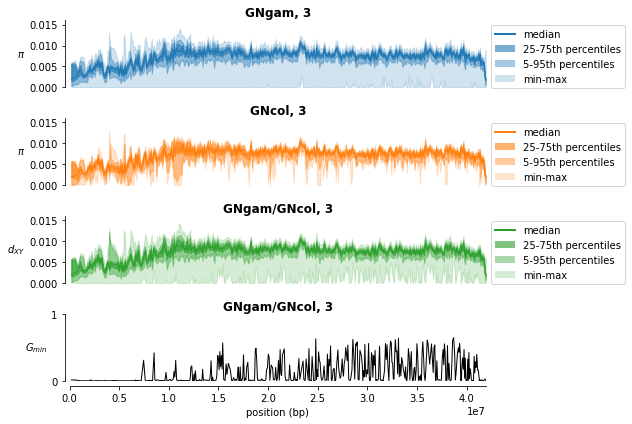

loading /mnt/70D89269D8922CFA/Genomes/dist_haps/L.bcolz


IndexError: list index out of range

In [87]:
run_2pop_analysis('GNgam', 'GNcol')

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 84, 85, 86, 87, 88, 89, 90, 94, 95, 96, 106, 107, 108, 109, 110, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 162, 167, 168, 170, 171, 172, 175, 176, 177, 178, 179, 180, 181, 183, 187, 190, 193, 195, 196, 198, 199, 200, 201, 202, 208, 209, 212, 213, 216, 217, 225, 228, 231]


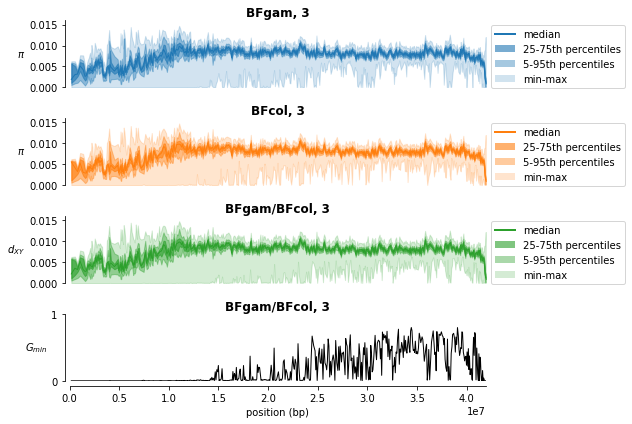

loading /mnt/70D89269D8922CFA/Genomes/dist_haps/L.bcolz


IndexError: list index out of range

In [96]:
run_2pop_analysis('BFgam', 'BFcol')

[5, 7, 14, 15, 21, 28, 29, 30, 36, 46, 54, 60]


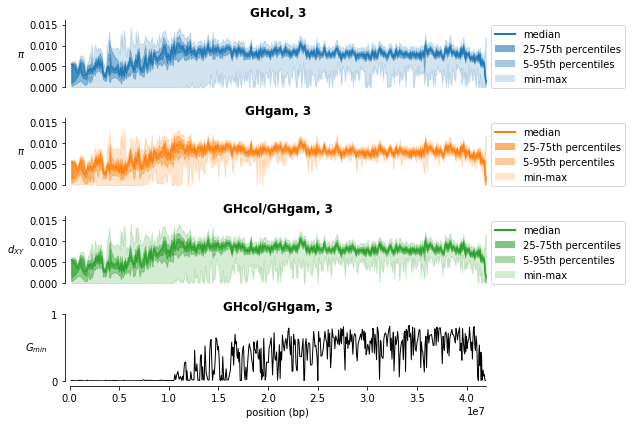

loading /mnt/70D89269D8922CFA/Genomes/dist_haps/L.bcolz


IndexError: list index out of range

In [98]:
run_2pop_analysis('GHcol', 'GHgam')